<a href="https://colab.research.google.com/github/Soedirman-Machine-Learning/Land-Cover-Classification/blob/main/Land_Cover_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **KLASIFIKASI TUTUPAN LAHAN BERDASARKAN SNI 7645-2010 PADA CITRA SATELIT MENGGUNAKAN CONVOLUTIONAL NEURAL NETWORK(CNN)**

# Preferensi

Penelitian Sebelumnya :
**Metode Convolutional Neural Network pada Gambar Google Earth Hutan Bambu di Jepang dengan .** 

*Shuntaro Watanabe, Kazuaki Sumi, Takeshi Ise*

link sebagai berikut : https://doi.org/10.1101/351643

**Note**

Penelitian ini mengambil konsep dari peneliti asal Jepang yang mengidentifikasikan vegatasi akurasi tinggi lahan hutan bamboo di beberapa wilayah Jepang, dengan klasisfikasi CNN, dan dilakukan dengan metode chopped-image. Selain itu, penelitian ini juga berasosiasi dengan Identifikasi Lahan Pertahian yang dilakukan oleh Fendy Prayogi dalam mengidentifikasi daerah sawah dan non-sawah menggunakan klasifikasi CNN.

Penelitian ini akan mengklasifikasikan citra satelit berdasarkan SNI 7645-2010 hingga tujuh kelas yang berbeda menggunakan CNN serta sliding window. 

Peneliti : Dhiemas Fatah Mujahid

Repositori tersedia pada : https://github.com/Soedirman-Machine-Learning/Land-Cover-Classification


# Mengimpor/Mengambil Fungsi Library

In [ ]:
!pip install slidingwindow
import slidingwindow as sw
import numpy as np
import os
import keras.backend as K
import keras
import pandas as pd
from keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras import activations
from keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
from skimage.io import imread, imsave
from skimage.transform import resize
from sklearn.utils.class_weight import compute_class_weight

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

# Mengambil Dataset dari Google Drive



In [ ]:
from google.colab import drive
drive.mount('/content/drive/')


Mounted at /content/drive/


In [ ]:
#Perintah untuk melihat list bagian dari file yang sudah diunduh dari Google Drive

!ls /content/drive/MyDrive/LCC/train
#gambar dengan label "k" adalah gambar dari fitur kebun teh(Kelas 1)"
#gambar dengan label "s" adalah gambar dari fitur sawah(Kelas 1)"
#gambar dengan label "w" adalah gambar dari fitur kebun sawit (Kelas 1)"
#gambar dengan label "h" adalah gambar dari fitur hutan (Kelas 2)"
#gambar dengan label "t" adalah gambar dari fitur tambang (Kelas 3)"
#gambar dengan label "p" adalah gambar dari fitur pemukiman (Kelas 4)"
#gambar dengan label "a" adalah gambar berfitur danau (Kelas 5)"

a10.jpg  a2.jpg   h5.jpg   k21.jpg  p14.jpg  p6.jpg   s22.jpg  t15.jpg	t7.jpg
a11.jpg  a3.jpg   h6.jpg   k22.jpg  p17.jpg  p7.jpg   s23.jpg  t16.jpg	t8.jpg
a12.jpg  a4.jpg   h7.jpg   k23.jpg  p18.jpg  p8.jpg   s24.jpg  t17.jpg	t9.jpg
a13.jpg  a5.jpg   h8.jpg   k24.jpg  p19.jpg  p9.jpg   s25.jpg  t18.jpg	w10.jpg
a14.jpg  a6.jpg   h9.jpg   k25.jpg  p1.jpg   s10.jpg  s2.jpg   t19.jpg	w11.jpg
a15.jpg  a7.jpg   k10.jpg  k2.jpg   p20.jpg  s11.jpg  s3.jpg   t1.jpg	w12.jpg
a16.jpg  a8.jpg   k11.jpg  k3.jpg   p21.jpg  s12.jpg  s4.jpg   t20.jpg	w1.jpg
a17.jpg  a9.jpg   k12.jpg  k4.jpg   p23.jpg  s13.jpg  s5.jpg   t21.jpg	w2.jpg
a18.jpg  chopped  k13.jpg  k5.jpg   p24.jpg  s14.jpg  s6.jpg   t22.jpg	w3.jpg
a19.jpg  h10.jpg  k14.jpg  k6.jpg   p25.jpg  s15.jpg  s7.jpg   t23.jpg	w4.jpg
a1.jpg	 h11.jpg  k15.jpg  k7.jpg   p26.jpg  s16.jpg  s8.jpg   t24.jpg	w5.jpg
a20.jpg  h12.jpg  k16.jpg  k8.jpg   p27.jpg  s17.jpg  s9.jpg   t25.jpg	w6.jpg
a21.jpg  h13.jpg  k17.jpg  k9.jpg   p28.jpg  s18.jpg  t10.jpg  

#Menampilkan Gambar Pelatihan

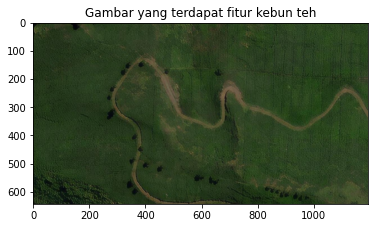

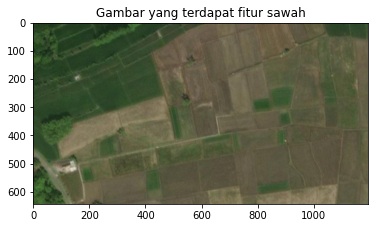

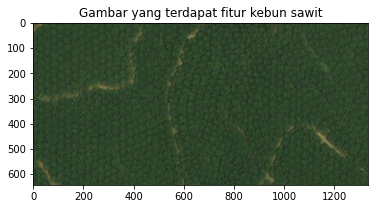

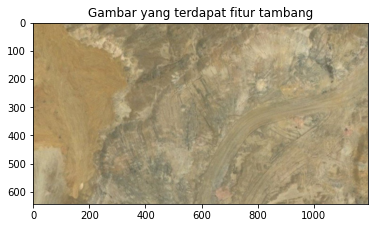

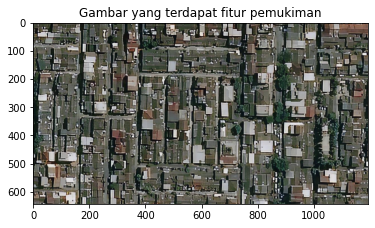

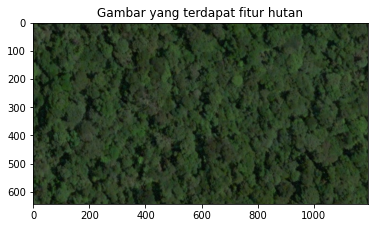

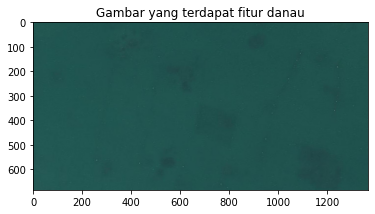

In [ ]:
#Gambar yang terdapat fitur kebun teh
plt.title("Gambar yang terdapat fitur kebun teh")
plt.imshow(imread("/content/drive/MyDrive/LCC/train/k6.jpg"))
plt.show()

#Gambar yang terdapat fitur sawah
plt.title("Gambar yang terdapat fitur sawah")
plt.imshow(imread("/content/drive/MyDrive/LCC/train/s2.jpg"))
plt.show()

#Gambar yang terdapat fitur kebun sawit
plt.title("Gambar yang terdapat fitur kebun sawit")
plt.imshow(imread("/content/drive/MyDrive/LCC/train/w4.jpg"))
plt.show()

#Gambar yang terdapat fitur tambang
plt.title("Gambar yang terdapat fitur tambang")
plt.imshow(imread("/content/drive/MyDrive/LCC/train/t7.jpg"))
plt.show()

#Gambar yang terdapat fitur pemukiman
plt.title("Gambar yang terdapat fitur pemukiman")
plt.imshow(imread("/content/drive/MyDrive/LCC/train/p3.jpg"))
plt.show()

#Gambar yang terdapat fitur hutan
plt.title("Gambar yang terdapat fitur hutan")
plt.imshow(imread("/content/drive/MyDrive/LCC/train/h5.jpg"))
plt.show()

#Gambar yang terdapat fitur danau
plt.title("Gambar yang terdapat fitur danau")
plt.imshow(imread("/content/drive/MyDrive/LCC/train/a7.jpg"))
plt.show()


# Membuat "patches" dari setiap gambar menggunakan metode sliding window

**Apa itu *Sliding Window* ?**

*Sliding window* adalah window yang bergeser untuk memprediksi dan mencari area objek yang benar. Suatu proses deteksi objek memerlukan teknik lokalisasi 
untuk menemukan area objek. Pengaplikasian Sliding Window dipisahkan ke dalam 7 batch yang mewakili masing masing kelas



In [ ]:
#Sliding Window Batch 1
def save_to_folder(img_path,directory,size=56,overlap=0.1):
    #Membaca gambar path penyimpanan window ke direktori/file yang spesifik
    img = imread(img_path)
    basename = os.path.basename(img_path)
    fname = os.path.splitext(basename)[0]
    windows = sw.generate(img, sw.DimOrder.HeightWidthChannel, size, overlap)
    for i,window in enumerate(windows):
        ii = str("{0:05d}".format(i))
        _fname = fname + "_" + ii + ".jpg"
        _img = img[window.indices()]
        if _img.shape !=(size,size,3):
            continue
        img_target_path = os.path.join(directory,_fname)
        
        imsave(img_target_path,_img, check_contrast=False)

files = os.listdir("/content/drive/MyDrive/LCC/train")
files = [x for x in files if x.endswith(".jpg")]

#Menyimpan gambar yang telah dicacah pada folder chopped
for file in files:
    save_directory = "/content/drive/MyDrive/LCC/train/chopped"
    file = os.path.join("/content/drive/MyDrive/LCC/train",file)
    save_to_folder(file,save_directory)

# Dataset Pelatihan

Dataset yang digunakan dalam Model Performa Klasifikasi akurasi, Recall Rate dan Presisi. Data pelatihan yang telah dichop sehingga menghasilkan gambar baru, lalu kita klasifikasikan hasilnya dengan empat kategori berupa :  *true positive* (TP), *false positive* (FP), *false negative* (FN), dan *true negative* (TN). 
Dengan ketentuan prediksi benar atau salah dan gambar sesuai dengan kelas masing-masing diberi label kelasnya

In [ ]:
#Array Dataset Batch 1
#Mengembalikan daftar gambar yang telah diacak pada direktori
#Data yang dilakukan pada model evaluasi

#Mengambil citra dataset yang telah dipotong
files = os.listdir("/content/drive/MyDrive/LCC/train/chopped")
files = [x for x in files if x.endswith(".jpg")]

#Memuat dataset Pelatihan dalam bentuk array
x = []
y = []

for file in files:
    if file.startswith("s"):
        label = [1,0,0,0,0,0]
    elif file.startswith("w"):
        label = [0,1,0,0,0,0]
    elif file.startswith("h"):
        label = [0,1,0,0,0,0]
    elif file.startswith("k"):
        label = [0,0,1,0,0,0]
    elif file.startswith("t"):
        label = [0,0,0,1,0,0]
    elif file.startswith("p"):
        label = [0,0,0,0,1,0]
    elif file.startswith("a"):
        label = [0,0,0,0,0,1]
    
    img_path = os.path.join("/content/drive/MyDrive/LCC/train/chopped",file)
    img = load_img(img_path)
    img = img_to_array(img)/255
    x.append(img)
    y.append(label)

X1 = np.array(x)
Y1 = np.array(y)
print("Bentuk array dari dataset train (pelatihan) adalah :", (X1.shape,Y1.shape))

Bentuk array dari dataset train (pelatihan) adalah : ((48972, 56, 56, 3), (48972, 6))


**Persiapan Data Testing**

In [ ]:
#Sliding Window Batch 1
def save_to_folder(img_path,directory,size=56,overlap=0.1):
    #Membaca gambar path penyimpanan window ke direktori/file yang spesifik
    img = imread(img_path)
    basename = os.path.basename(img_path)
    fname = os.path.splitext(basename)[0]
    windows = sw.generate(img, sw.DimOrder.HeightWidthChannel, size, overlap)
    for i,window in enumerate(windows):
        ii = str("{0:05d}".format(i))
        _fname = fname + "_" + ii + ".jpg"
        _img = img[window.indices()]
        if _img.shape !=(size,size,3):
            continue
        img_target_path = os.path.join(directory,_fname)
        
        imsave(img_target_path,_img, check_contrast=False)

files = os.listdir("/content/drive/MyDrive/LCC/testing")
files = [x for x in files if x.endswith(".jpg")]

#Menyimpan gambar yang telah dicacah pada folder chopped
for file in files:
    save_directory = "/content/drive/MyDrive/LCC/testing/potong"
    file = os.path.join("/content/drive/MyDrive/LCC/testing",file)
    save_to_folder(file,save_directory)

In [ ]:
files = os.listdir("/content/drive/MyDrive/LCC/testing/potong")
files = [x for x in files if x.endswith(".jpg")]

#Memuat dataset pengujian

X = []
Y = []

for file in files:
    if file.startswith("s"):
        label = [1,0,0,0,0,0]
    elif file.startswith("w"):
        label = [0,1,0,0,0,0]
    elif file.startswith("h"):
        label = [0,1,0,0,0,0]
    elif file.startswith("k"):
        label = [0,0,1,0,0,0]
    elif file.startswith("t"):
        label = [0,0,0,1,0,0]
    elif file.startswith("p"):
        label = [0,0,0,0,1,0]
    elif file.startswith("a"):
        label = [0,0,0,0,0,1]

    
    img_path1 = os.path.join("/content/drive/MyDrive/LCC/testing/potong",file)
    img1 = load_img(img_path1)
    img1 = img_to_array(img1)/255.
    img1 = resize(img1,(56,56))
    X.append(img1)
    Y.append(label)

X1_test = np.array(X)
Y1_test = np.array(Y)
print("Bentuk array dari dataset test adalah :", (X1_test.shape,Y1_test.shape))

Bentuk array dari dataset test adalah : ((113154, 56, 56, 3), (113154, 6))


In [ ]:
from sklearn.model_selection import train_test_split

train_x, valid_x, train_y, valid_y = train_test_split(X1,
                                                      Y1,
                                                      test_size=0.15,
                                                      stratify = Y1)

print("Bentuk array dari dataset train (pelatihan) adalah:",train_x.shape,train_y.shape)
print("Bentuk array dari dataset validation adalah:",valid_x.shape,valid_y.shape)
#print("Bentuk array dari dataset test (pengujian) adalah:",x_test.shape,y_test.shape)

Bentuk array dari dataset train (pelatihan) adalah: (41626, 56, 56, 3) (41626, 6)
Bentuk array dari dataset validation adalah: (7346, 56, 56, 3) (7346, 6)


#Pembuatan Model

In [ ]:
import tensorflow as tf
from sklearn import svm, datasets
from sklearn.metrics import confusion_matrix
import pandas as pd


In [ ]:
IMG_SHAPE = (56, 56, 3)
# Membuat model dasar (base model) dari pre-trained model MobileNet
base_model = tf.keras.applications.VGG16(input_shape=IMG_SHAPE,
                                              include_top=False, 
                                              weights='imagenet')

58900480/58889256 [==============================] - 1s 0us/step


In [ ]:
base_model.trainable = True
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 56, 56, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 56, 56, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 56, 56, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 28, 28, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 28, 28, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 28, 28, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 14, 14, 128)       0     

In [ ]:
model = tf.keras.Sequential([
    base_model,  
    #tf.keras.layers.Conv2D(16,(3,3),name="conv1",input_shape=(56,56,3),activation="relu",padding="same"),   
    #tf.keras.layers.MaxPool2D((2,2),name="pool1"),
    #tf.keras.layers.Dropout(0.5),
    #tf.keras.layers.Conv2D(32,(3,3),name="conv2",padding="same"),
    #tf.keras.layers.Activation("relu"),
    #tf.keras.layers.MaxPool2D((2,2),name="pool2"),
    #tf.keras.layers.Dropout(0.5),
    #tf.keras.layers.Conv2D(32,(3,3),name="conv3",padding="same"),10
    #tf.keras.layers.Activation("relu"),
    #tf.keras.layers.MaxPool2D((2,2),name="pool3"),
    #tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Flatten(),  
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(32,activation="relu"),
    tf.keras.layers.Dense(6,activation = tf.keras.activations.softmax)]
    )

model.compile(optimizer="adam",loss="binary_crossentropy",metrics=["acc"])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 32)                16416     
                                                                 
 dense_1 (Dense)             (None, 6)                 198       
                                                                 
Total params: 14,731,302
Trainable params: 14,731,302
Non-trainable params: 0
_________________________________________________________________


In [ ]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

#Menyimpan model bobot yang terbaik selama training
ckpt = ModelCheckpoint("/content/drive/MyDrive/LCC/vgg16/valid/tanah.h5", monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
history= model.fit(train_x,
                    train_y,
                    batch_size=500,
                    epochs = 25,
                    validation_data=(valid_x,valid_y),
                    callbacks = [ckpt]
                    )

Epoch 1/25
84/84 [==============================] - ETA: 0s - loss: 0.7725 - acc: 0.1733
Epoch 1: val_loss improved from inf to 0.45142, saving model to /content/drive/MyDrive/LCC/vgg16/valid/tanah.h5
84/84 [==============================] - 114s 1s/step - loss: 0.7725 - acc: 0.1733 - val_loss: 0.4514 - val_acc: 0.2561
Epoch 2/25
84/84 [==============================] - ETA: 0s - loss: 0.4105 - acc: 0.2813
Epoch 2: val_loss improved from 0.45142 to 0.31449, saving model to /content/drive/MyDrive/LCC/vgg16/valid/tanah.h5
84/84 [==============================] - 79s 942ms/step - loss: 0.4105 - acc: 0.2813 - val_loss: 0.3145 - val_acc: 0.4054
Epoch 3/25
84/84 [==============================] - ETA: 0s - loss: 0.2624 - acc: 0.5861
Epoch 3: val_loss improved from 0.31449 to 0.17633, saving model to /content/drive/MyDrive/LCC/vgg16/valid/tanah.h5
84/84 [==============================] - 79s 942ms/step - loss: 0.2624 - acc: 0.5861 - val_loss: 0.1763 - val_acc: 0.7713
Epoch 4/25
84/84 [=======

#Menggambarkan Hasil Pelatihan

In [ ]:
model=tf.keras.models.load_model("/content/drive/MyDrive/LCC/vgg16/h5/vgg16.h5")

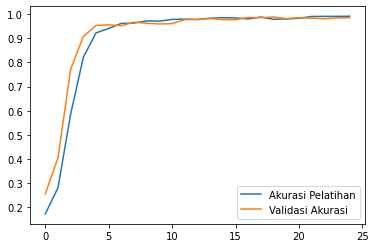

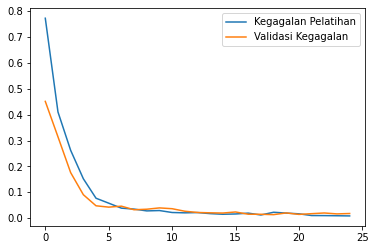

In [ ]:
plt.plot(history.history["acc"],label="Akurasi Pelatihan")
plt.plot(history.history["val_acc"],label="Validasi Akurasi")
plt.legend()
plt.show()

plt.plot(history.history["loss"],label="Kegagalan Pelatihan")
plt.plot(history.history["val_loss"],label="Validasi Kegagalan")
plt.legend()
plt.show()

# Evaluasi dengan model


In [ ]:
model=tf.keras.models.load_model("/content/drive/MyDrive/LCC/vgg16/h5/vgg16.h5")

In [ ]:
#Memeriksa matriks model
print(model.metrics_names)
#Evaluasi data training
print(model.evaluate(train_x,train_y))
#Evaluasi validasi data
print(model.evaluate(valid_x,valid_y))

['loss', 'acc']
1522/1522 [==============================] - 15s 10ms/step - loss: 0.0045 - acc: 0.9954
[0.004528223071247339, 0.9953991770744324]
269/269 [==============================] - 3s 10ms/step - loss: 0.0082 - acc: 0.9927
[0.008248280733823776, 0.9926676154136658]


In [ ]:
#Memeriksa matriks model
print(model.metrics_names)
#Evaluasi data testing
print(model.evaluate(X1_test,Y1_test))

['loss', 'acc']
3537/3537 [==============================] - 45s 10ms/step - loss: 0.1806 - acc: 0.8919
[0.1806458681821823, 0.8919436931610107]


# Matriks Evaluasi Deep Learning #

## Validasi

In [ ]:
y_pred_class =np.argmax(model.predict(x =valid_x), axis=-1)
y_pred_class.shape
#Jumlah data prediksi dari data test
print('Jumlah data prediksi hasil dari dataset pengujian pada penelitian :', y_pred_class.transpose())

Jumlah data prediksi hasil dari dataset pengujian pada penelitian : [1 3 5 ... 1 5 3]


In [ ]:
y_true = []
for i in valid_y:
    y_true.append(np.argmax(i))

In [ ]:
#Klasifikasi Tunggal
#from sklearn import metrics
#print("Akurasi pada data Pulau Jawa:",metrics.accuracy_score(Y1_test, y_pred_class))

#Klasifikasi Multi Kelas
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred_class))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1281
           1       1.00      1.00      1.00      2486
           2       0.98      0.99      0.98      1145
           3       0.99      1.00      0.99      1170
           4       0.99      1.00      0.99      1205
           5       1.00      1.00      1.00      1305

    accuracy                           0.99      8592
   macro avg       0.99      0.99      0.99      8592
weighted avg       0.99      0.99      0.99      8592



### Confusion Matriks


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

#Get the confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred_class)
print(cf_matrix)

[[1251    0   17   10    3    0]
 [   0 2476    5    2    3    0]
 [   5    1 1133    3    3    0]
 [   0    0    0 1165    5    0]
 [   0    0    2    2 1201    0]
 [   0    0    0    0    2 1303]]


In [ ]:
nrml_cf = np.zeros((7,7))
row_sums = cf_matrix.sum(axis=1)
for i in range(len(cf_matrix)):
  for j in range(len(cf_matrix)):
    nrml_cf[i][j] = cf_matrix[i][j] / row_sums[i]

In [ ]:
np.around(nrml_cf, decimals = 3)

array([[0.977, 0.   , 0.013, 0.008, 0.002, 0.   , 0.   ],
       [0.   , 0.996, 0.002, 0.001, 0.001, 0.   , 0.   ],
       [0.004, 0.001, 0.99 , 0.003, 0.003, 0.   , 0.   ],
       [0.   , 0.   , 0.   , 0.996, 0.004, 0.   , 0.   ],
       [0.   , 0.   , 0.002, 0.002, 0.997, 0.   , 0.   ],
       [0.   , 0.   , 0.   , 0.   , 0.002, 0.998, 0.   ],
       [0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ]])

In [ ]:
#KOMPUTASI TP,TN,FP,FN

#Kelas 0
TP0 = cf_matrix[0,0]
TN01 = cf_matrix[1,1] + cf_matrix[1,2] + cf_matrix[1,3] + cf_matrix[1,4] + cf_matrix[1,5] 
TN02 = cf_matrix[2,1] + cf_matrix[2,2] + cf_matrix[2,3] + cf_matrix[2,4] + cf_matrix[2,5]
TN03 = cf_matrix[3,1] + cf_matrix[3,2] + cf_matrix[3,3] + cf_matrix[3,4] + cf_matrix[3,5]
TN04 = cf_matrix[4,1] + cf_matrix[4,2] + cf_matrix[4,3] + cf_matrix[4,4] + cf_matrix[4,5]
TN05 = cf_matrix[5,1] + cf_matrix[5,2] + cf_matrix[5,3] + cf_matrix[5,4] + cf_matrix[5,5]
TN0 = TN01 + TN02 + TN03 + TN04 + TN05
FP0 = cf_matrix[0,1] + cf_matrix[0,2] + cf_matrix[0,3] + cf_matrix[0,4] + cf_matrix[0,5]
FN0 = cf_matrix[1,0] + cf_matrix[2,0] + cf_matrix[3,0] + cf_matrix[4,0] + cf_matrix[5,0]

#KELAS 1
TP1 = cf_matrix[1,1]
TN10 = cf_matrix[0,0] + cf_matrix[0,2] + cf_matrix[0,3] + cf_matrix[0,4] + cf_matrix[0,5]
TN12 = cf_matrix[2,0] + cf_matrix[2,2] + cf_matrix[2,3] + cf_matrix[2,4] + cf_matrix[2,5]
TN13 = cf_matrix[3,0] + cf_matrix[3,2] + cf_matrix[3,3] + cf_matrix[3,4] + cf_matrix[3,5]
TN14 = cf_matrix[4,0] + cf_matrix[4,2] + cf_matrix[4,3] + cf_matrix[4,4] + cf_matrix[4,5]
TN15 = cf_matrix[5,0] + cf_matrix[5,2] + cf_matrix[5,3] + cf_matrix[5,4] + cf_matrix[5,5]
TN1 = TN10 + TN12 + TN13 + TN14 + TN15
FP1 = cf_matrix[1,0] + cf_matrix[1,2] + cf_matrix[1,3] + cf_matrix[1,4] + cf_matrix[1,5]
FN1 = cf_matrix[0,1] + cf_matrix[2,1] + cf_matrix[3,1] + cf_matrix[4,1] + cf_matrix[5,1]

#KELAS 2

TP2 = cf_matrix[2,2]
TN20 = cf_matrix[0,0] + cf_matrix[0,1] + cf_matrix[0,3] + cf_matrix[0,4] + cf_matrix[0,5]
TN21 = cf_matrix[1,0] + cf_matrix[1,1] + cf_matrix[1,3] + cf_matrix[1,4] + cf_matrix[1,5]
TN23 = cf_matrix[3,0] + cf_matrix[3,1] + cf_matrix[3,3] + cf_matrix[3,4] + cf_matrix[3,5]
TN24 = cf_matrix[4,0] + cf_matrix[4,1] + cf_matrix[4,3] + cf_matrix[4,4] + cf_matrix[4,5]
TN25 = cf_matrix[5,0] + cf_matrix[5,1] + cf_matrix[5,3] + cf_matrix[5,4] + cf_matrix[5,5]
TN2 = TN20 + TN21 + TN23 + TN24 + TN25
FP2 = cf_matrix[2,0] + cf_matrix[2,1] + cf_matrix[2,3] + cf_matrix[2,4] + cf_matrix[2,5]
FN2 = cf_matrix[0,2] + cf_matrix[1,2] + cf_matrix[3,2] + cf_matrix[4,2] + cf_matrix[5,2]

#KELAS 3
TP3 = cf_matrix[3,3]
TN30 = cf_matrix[0,0] + cf_matrix[0,1] + cf_matrix[0,2] + cf_matrix[0,4] + cf_matrix[0,5]
TN31 = cf_matrix[1,0] + cf_matrix[1,1] + cf_matrix[1,2] + cf_matrix[1,4] + cf_matrix[1,5]
TN32 = cf_matrix[2,0] + cf_matrix[2,1] + cf_matrix[2,2] + cf_matrix[2,4] + cf_matrix[2,5]
TN34 = cf_matrix[4,0] + cf_matrix[4,1] + cf_matrix[4,2] + cf_matrix[4,4] + cf_matrix[4,5]
TN35 = cf_matrix[5,0] + cf_matrix[5,1] + cf_matrix[5,2] + cf_matrix[5,4] + cf_matrix[5,5]
TN3 = TN30 + TN31 + TN32 + TN34 + TN35
FP3 = cf_matrix[3,0] + cf_matrix[3,1] + cf_matrix[3,2] + cf_matrix[3,4] + cf_matrix[3,5]
FN3 = cf_matrix[0,3] + cf_matrix[1,3] + cf_matrix[2,3] + cf_matrix[4,3] + cf_matrix[5,3]

#KELAS 4
TP4 = cf_matrix[4,4]
TN40 = cf_matrix[0,0] + cf_matrix[0,1] + cf_matrix[0,2] + cf_matrix[0,3] + cf_matrix[0,5]
TN41 = cf_matrix[1,0] + cf_matrix[1,1] + cf_matrix[1,2] + cf_matrix[1,3] + cf_matrix[1,5]
TN42 = cf_matrix[2,0] + cf_matrix[2,1] + cf_matrix[2,2] + cf_matrix[2,3] + cf_matrix[2,5]
TN43 = cf_matrix[3,0] + cf_matrix[3,1] + cf_matrix[3,2] + cf_matrix[3,3] + cf_matrix[3,5]
TN45 = cf_matrix[5,0] + cf_matrix[5,1] + cf_matrix[5,2] + cf_matrix[5,3] + cf_matrix[5,5]
TN4 = TN40 + TN41 + TN42 + TN43 + TN45
FP4 = cf_matrix[4,0] + cf_matrix[4,1] + cf_matrix[4,2] + cf_matrix[4,3] + cf_matrix[4,5]
FN4 = cf_matrix[0,4] + cf_matrix[1,4] + cf_matrix[2,4] + cf_matrix[3,4] + cf_matrix[5,4]

#KELAS 5
TP5 = cf_matrix[5,5]
TN50 = cf_matrix[0,0] + cf_matrix[0,1] + cf_matrix[0,2] + cf_matrix[0,3] + cf_matrix[0,4]
TN51 = cf_matrix[1,0] + cf_matrix[1,1] + cf_matrix[1,2] + cf_matrix[1,3] + cf_matrix[1,4]
TN52 = cf_matrix[2,0] + cf_matrix[2,1] + cf_matrix[2,2] + cf_matrix[2,3] + cf_matrix[2,4]
TN53 = cf_matrix[3,0] + cf_matrix[3,1] + cf_matrix[3,2] + cf_matrix[3,3] + cf_matrix[3,4]
TN54 = cf_matrix[4,0] + cf_matrix[4,1] + cf_matrix[4,2] + cf_matrix[4,3] + cf_matrix[4,4]
TN5 = TN50 + TN51 + TN52 + TN53 + TN54
FP5 = cf_matrix[5,0] + cf_matrix[5,1] + cf_matrix[5,2] + cf_matrix[5,3] + cf_matrix[5,4]
FN5 = cf_matrix[0,5] + cf_matrix[1,5] + cf_matrix[2,5] + cf_matrix[3,5] + cf_matrix[4,5]

In [ ]:
print(TP0)
print(TP1)
print(TP2)
print(TP3)
print(TP4)
print(TP5)
print("\n")
print(TN0)
print(TN1)
print(TN2)
print(TN3)
print(TN4)
print(TN5)

1251
2476
1133
1165
1201
1303


7306
6105
7423
7405
7371
7287


In [ ]:
print(FP0)
print(FP1)
print(FP2)
print(FP3)
print(FP4)
print(FP5)
print("\n")
print(FN0)
print(FN1)
print(FN2)
print(FN3)
print(FN4)
print(FN5)

30
10
12
5
4
2


5
1
24
17
16
0


### Metrik Unjuk Kerja Deep Learning

In [ ]:
#Parameter Kelas 0
Akurasi0 = (TP0 + TN0)/(TP0+TN0+FP0+FN0)
Error0 = (FP0+FN0)/(TP0+TN0+FP0+FN0)
Presisi0 = TP0/(TP0+FP0)
Recall0 = TP0/(TP0+FN0)
F1_Score0 = (2*TP0)/((2*TP0)+FP0+FN0)
print("Nilai parameter kelas 0 :\n Akurasi =", Akurasi0)
print("\n")
print(" Error = ", Error0)
print("\n")
print(" Presisi = ",Presisi0)
print("\n")
print(" Recall = ",Recall0)
print("\n")
print(" F1_Score = ",F1_Score0)
print("\n")
print("\n")
#Parameter Kelas 1
Akurasi1 = (TP1 + TN1)/(TP1+TN1+FP1+FN1)
Error1 = (FP1+FN1)/(TP1+TN1+FP1+FN1)
Presisi1 = TP1/(TP1+FP1)
Recall1 = TP1/(TP1+FN1)
F1_Score1 = (2*TP1)/((2*TP1)+FP1+FN1)
print("Nilai parameter kelas 1 :\n Akurasi =", Akurasi1)
print("\n")
print(" Error = ", Error1)
print("\n")
print(" Presisi = ",Presisi1)
print("\n")
print(" Recall = ",Recall1)
print("\n")
print(" F1_Score = ",F1_Score1)
print("\n")
print("\n")
#Parameter Kelas 2
Akurasi2 = (TP2 + TN2)/(TP2+TN2+FP2+FN2)
Error2 = (FP2+FN2)/(TP2+TN2+FP2+FN2)
Presisi2 = TP2/(TP2+FP2)
Recall2 = TP2/(TP2+FN2)
F1_Score2 = (2*TP2)/((2*TP2)+FP2+FN2)
print("Nilai parameter kelas 2 :\n Akurasi =", Akurasi2)
print("\n")
print(" Error = ", Error2)
print("\n")
print(" Presisi = ",Presisi2)
print("\n")
print(" Recall = ",Recall2)
print("\n")
print(" F1_Score = ",F1_Score2)
print("\n")
print("\n")
#Parameter Kelas 3
Akurasi3 = (TP3 + TN3)/(TP3+TN3+FP3+FN3)
Error3 = (FP3+FN3)/(TP3+TN3+FP3+FN3)
Presisi3 = TP3/(TP3+FP3)
Recall3 = TP3/(TP3+FN3)
F1_Score3 = (2*TP3)/((2*TP3)+FP3+FN3)
print("Nilai parameter kelas 3 :\n Akurasi =", Akurasi3)
print("\n")
print(" Error = ", Error3)
print("\n")
print(" Presisi = ",Presisi3)
print("\n")
print(" Recall = ",Recall3)
print("\n")
print(" F1_Score = ",F1_Score3)
print("\n")
print("\n")
#Parameter Kelas 4
Akurasi4 = (TP4 + TN4)/(TP4+TN4+FP4+FN4)
Error4 = (FP4+FN4)/(TP4+TN4+FP4+FN4)
Presisi4 = TP4/(TP4+FP4)
Recall4 = TP4/(TP4+FN4)
F1_Score4 = (2*TP4)/((2*TP4)+FP4+FN4)
print("Nilai parameter kelas 4 :\n Akurasi =", Akurasi4)
print("\n")
print(" Error = ", Error4)
print("\n")
print(" Presisi = ",Presisi4)
print("\n")
print(" Recall = ",Recall4)
print("\n")
print(" F1_Score = ",F1_Score4)
print("\n")
print("\n")
#Parameter Kelas 5
Akurasi5 = (TP5 + TN5)/(TP5+TN5+FP5+FN5)
Error5 = (FP5+FN5)/(TP5+TN5+FP5+FN5)
Presisi5 = TP5/(TP5+FP5)
Recall5 = TP5/(TP5+FN5)
F1_Score5 = (2*TP5)/((2*TP5)+FP5+FN5)
print("Nilai parameter kelas 5 :\n Akurasi =", Akurasi5)
print("\n")
print(" Error = ", Error5)
print("\n")
print(" Presisi = ",Presisi5)
print("\n")
print(" Recall = ",Recall5)
print("\n")
print(" F1_Score = ",F1_Score5)
print("\n")
print("\n")




Nilai parameter kelas 0 :
 Akurasi = 0.9959264432029795


 Error =  0.004073556797020484


 Presisi =  0.9765807962529274


 Recall =  0.9960191082802548


 F1_Score =  0.9862041781631848




Nilai parameter kelas 1 :
 Akurasi = 0.998719739292365


 Error =  0.0012802607076350093


 Presisi =  0.99597747385358


 Recall =  0.9995962858296327


 F1_Score =  0.997783598629861




Nilai parameter kelas 2 :
 Akurasi = 0.9958100558659218


 Error =  0.004189944134078212


 Presisi =  0.9895196506550218


 Recall =  0.9792566983578219


 F1_Score =  0.9843614248479583




Nilai parameter kelas 3 :
 Akurasi = 0.99743947858473


 Error =  0.0025605214152700185


 Presisi =  0.9957264957264957


 Recall =  0.9856175972927242


 F1_Score =  0.9906462585034014




Nilai parameter kelas 4 :
 Akurasi = 0.9976722532588455


 Error =  0.0023277467411545625


 Presisi =  0.9966804979253112


 Recall =  0.9868529170090387


 F1_Score =  0.9917423616845582




Nilai parameter kelas 5 :
 Akurasi = 0.9997

In [ ]:
df1=pd.DataFrame(
    {
        "Parameter" : ["Kelas 0","Kelas 1","Kelas 2","Kelas 3","Kelas 4","Kelas 5"],
        "Akurasi" : [Akurasi0, Akurasi1, Akurasi2, Akurasi3, Akurasi4, Akurasi5],
        "Loss" : [Error0, Error1, Error2, Error3, Error4, Error5],
        "Presisi" : [Presisi0, Presisi1, Presisi2, Presisi3, Presisi4, Presisi5],
        "Recall" : [Recall0, Recall1, Recall2, Recall3, Recall4, Recall5],
        "F1_Score" : [F1_Score0, F1_Score1, F1_Score2, F1_Score3, F1_Score4, F1_Score5],
    },
    index=[0,1,2,3,4,5,],
)
frame = [df1]
result = pd.concat(frame)
print(result)

  Parameter   Akurasi      Loss   Presisi    Recall  F1_Score
0   Kelas 0  0.995926  0.004074  0.976581  0.996019  0.986204
1   Kelas 1  0.998720  0.001280  0.995977  0.999596  0.997784
2   Kelas 2  0.995810  0.004190  0.989520  0.979257  0.984361
3   Kelas 3  0.997439  0.002561  0.995726  0.985618  0.990646
4   Kelas 4  0.997672  0.002328  0.996680  0.986853  0.991742
5   Kelas 5  0.999767  0.000233  0.998467  1.000000  0.999233


MENAMPILAN NILAI PARAMETER PENELITIAN


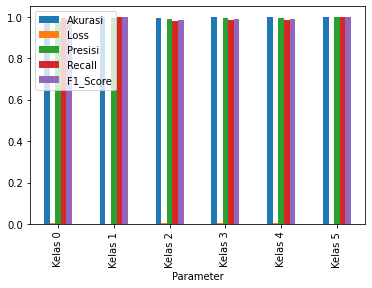

In [ ]:
#Menampilkan Nilai Parameter masing-masing kelas
df1.plot(kind='bar',x='Parameter',y=['Akurasi','Loss','Presisi','Recall','F1_Score'])


## Testing

In [ ]:
y_pred_class =np.argmax(model.predict(x =X1_test), axis=-1)
y_pred_class.shape
#Jumlah data prediksi dari data test
print('Jumlah data prediksi hasil dari dataset pengujian pada penelitian :', y_pred_class.transpose())

Jumlah data prediksi hasil dari dataset pengujian pada penelitian : [1 1 1 ... 5 5 5]


In [ ]:
y_true = []
for i in Y1_test:
    y_true.append(np.argmax(i))

In [ ]:
#Klasifikasi Tunggal
#from sklearn import metrics
#print("Akurasi pada data Pulau Jawa:",metrics.accuracy_score(Y1_test, y_pred_class))

#Klasifikasi Multi Kelas
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred_class))

              precision    recall  f1-score   support

           0       0.92      0.98      0.95     17277
           1       0.99      0.76      0.86     32864
           2       0.89      0.96      0.92     15080
           3       0.89      0.92      0.91     15600
           4       0.70      0.97      0.81     16172
           5       0.99      0.89      0.94     16161

    accuracy                           0.89    113154
   macro avg       0.90      0.91      0.90    113154
weighted avg       0.91      0.89      0.89    113154



### Confusion Matrix

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

#Get the confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred_class)
print(cf_matrix)

[[16956     0   227    61    27     6]
 [    7 25021  1518    54  6234    30]
 [  281    95 14498    28   146    32]
 [  943    12    16 14382   239     8]
 [  231    45    72   129 15652    43]
 [    3   158     0  1524    58 14418]]


In [ ]:
nrml_cf = np.zeros((6,6))
row_sums = cf_matrix.sum(axis=1)
for i in range(len(cf_matrix)):
  for j in range(len(cf_matrix)):
    nrml_cf[i][j] = cf_matrix[i][j] / row_sums[i]

In [ ]:
nrml_cf = np.around(nrml_cf, decimals = 3)
print(nrml_cf)

[[0.981 0.    0.013 0.004 0.002 0.   ]
 [0.    0.761 0.046 0.002 0.19  0.001]
 [0.019 0.006 0.961 0.002 0.01  0.002]
 [0.06  0.001 0.001 0.922 0.015 0.001]
 [0.014 0.003 0.004 0.008 0.968 0.003]
 [0.    0.01  0.    0.094 0.004 0.892]]


In [ ]:
#KOMPUTASI TP,TN,FP,FN

#Kelas 0
TP0 = cf_matrix[0,0]
TN01 = cf_matrix[1,1] + cf_matrix[1,2] + cf_matrix[1,3] + cf_matrix[1,4] + cf_matrix[1,5] 
TN02 = cf_matrix[2,1] + cf_matrix[2,2] + cf_matrix[2,3] + cf_matrix[2,4] + cf_matrix[2,5]
TN03 = cf_matrix[3,1] + cf_matrix[3,2] + cf_matrix[3,3] + cf_matrix[3,4] + cf_matrix[3,5]
TN04 = cf_matrix[4,1] + cf_matrix[4,2] + cf_matrix[4,3] + cf_matrix[4,4] + cf_matrix[4,5]
TN05 = cf_matrix[5,1] + cf_matrix[5,2] + cf_matrix[5,3] + cf_matrix[5,4] + cf_matrix[5,5]
TN0 = TN01 + TN02 + TN03 + TN04 + TN05
FP0 = cf_matrix[0,1] + cf_matrix[0,2] + cf_matrix[0,3] + cf_matrix[0,4] + cf_matrix[0,5]
FN0 = cf_matrix[1,0] + cf_matrix[2,0] + cf_matrix[3,0] + cf_matrix[4,0] + cf_matrix[5,0]

#KELAS 1
TP1 = cf_matrix[1,1]
TN10 = cf_matrix[0,0] + cf_matrix[0,2] + cf_matrix[0,3] + cf_matrix[0,4] + cf_matrix[0,5]
TN12 = cf_matrix[2,0] + cf_matrix[2,2] + cf_matrix[2,3] + cf_matrix[2,4] + cf_matrix[2,5]
TN13 = cf_matrix[3,0] + cf_matrix[3,2] + cf_matrix[3,3] + cf_matrix[3,4] + cf_matrix[3,5]
TN14 = cf_matrix[4,0] + cf_matrix[4,2] + cf_matrix[4,3] + cf_matrix[4,4] + cf_matrix[4,5]
TN15 = cf_matrix[5,0] + cf_matrix[5,2] + cf_matrix[5,3] + cf_matrix[5,4] + cf_matrix[5,5]
TN1 = TN10 + TN12 + TN13 + TN14 + TN15
FP1 = cf_matrix[1,0] + cf_matrix[1,2] + cf_matrix[1,3] + cf_matrix[1,4] + cf_matrix[1,5]
FN1 = cf_matrix[0,1] + cf_matrix[2,1] + cf_matrix[3,1] + cf_matrix[4,1] + cf_matrix[5,1]

#KELAS 2

TP2 = cf_matrix[2,2]
TN20 = cf_matrix[0,0] + cf_matrix[0,1] + cf_matrix[0,3] + cf_matrix[0,4] + cf_matrix[0,5]
TN21 = cf_matrix[1,0] + cf_matrix[1,1] + cf_matrix[1,3] + cf_matrix[1,4] + cf_matrix[1,5]
TN23 = cf_matrix[3,0] + cf_matrix[3,1] + cf_matrix[3,3] + cf_matrix[3,4] + cf_matrix[3,5]
TN24 = cf_matrix[4,0] + cf_matrix[4,1] + cf_matrix[4,3] + cf_matrix[4,4] + cf_matrix[4,5]
TN25 = cf_matrix[5,0] + cf_matrix[5,1] + cf_matrix[5,3] + cf_matrix[5,4] + cf_matrix[5,5]
TN2 = TN20 + TN21 + TN23 + TN24 + TN25
FP2 = cf_matrix[2,0] + cf_matrix[2,1] + cf_matrix[2,3] + cf_matrix[2,4] + cf_matrix[2,5]
FN2 = cf_matrix[0,2] + cf_matrix[1,2] + cf_matrix[3,2] + cf_matrix[4,2] + cf_matrix[5,2]

#KELAS 3
TP3 = cf_matrix[3,3]
TN30 = cf_matrix[0,0] + cf_matrix[0,1] + cf_matrix[0,2] + cf_matrix[0,4] + cf_matrix[0,5]
TN31 = cf_matrix[1,0] + cf_matrix[1,1] + cf_matrix[1,2] + cf_matrix[1,4] + cf_matrix[1,5]
TN32 = cf_matrix[2,0] + cf_matrix[2,1] + cf_matrix[2,2] + cf_matrix[2,4] + cf_matrix[2,5]
TN34 = cf_matrix[4,0] + cf_matrix[4,1] + cf_matrix[4,2] + cf_matrix[4,4] + cf_matrix[4,5]
TN35 = cf_matrix[5,0] + cf_matrix[5,1] + cf_matrix[5,2] + cf_matrix[5,4] + cf_matrix[5,5]
TN3 = TN30 + TN31 + TN32 + TN34 + TN35
FP3 = cf_matrix[3,0] + cf_matrix[3,1] + cf_matrix[3,2] + cf_matrix[3,4] + cf_matrix[3,5]
FN3 = cf_matrix[0,3] + cf_matrix[1,3] + cf_matrix[2,3] + cf_matrix[4,3] + cf_matrix[5,3]

#KELAS 4
TP4 = cf_matrix[4,4]
TN40 = cf_matrix[0,0] + cf_matrix[0,1] + cf_matrix[0,2] + cf_matrix[0,3] + cf_matrix[0,5]
TN41 = cf_matrix[1,0] + cf_matrix[1,1] + cf_matrix[1,2] + cf_matrix[1,3] + cf_matrix[1,5]
TN42 = cf_matrix[2,0] + cf_matrix[2,1] + cf_matrix[2,2] + cf_matrix[2,3] + cf_matrix[2,5]
TN43 = cf_matrix[3,0] + cf_matrix[3,1] + cf_matrix[3,2] + cf_matrix[3,3] + cf_matrix[3,5]
TN45 = cf_matrix[5,0] + cf_matrix[5,1] + cf_matrix[5,2] + cf_matrix[5,3] + cf_matrix[5,5]
TN4 = TN40 + TN41 + TN42 + TN43 + TN45
FP4 = cf_matrix[4,0] + cf_matrix[4,1] + cf_matrix[4,2] + cf_matrix[4,3] + cf_matrix[4,5]
FN4 = cf_matrix[0,4] + cf_matrix[1,4] + cf_matrix[2,4] + cf_matrix[3,4] + cf_matrix[5,4]

#KELAS 5
TP5 = cf_matrix[5,5]
TN50 = cf_matrix[0,0] + cf_matrix[0,1] + cf_matrix[0,2] + cf_matrix[0,3] + cf_matrix[0,4]
TN51 = cf_matrix[1,0] + cf_matrix[1,1] + cf_matrix[1,2] + cf_matrix[1,3] + cf_matrix[1,4]
TN52 = cf_matrix[2,0] + cf_matrix[2,1] + cf_matrix[2,2] + cf_matrix[2,3] + cf_matrix[2,4]
TN53 = cf_matrix[3,0] + cf_matrix[3,1] + cf_matrix[3,2] + cf_matrix[3,3] + cf_matrix[3,4]
TN54 = cf_matrix[4,0] + cf_matrix[4,1] + cf_matrix[4,2] + cf_matrix[4,3] + cf_matrix[4,4]
TN5 = TN50 + TN51 + TN52 + TN53 + TN54
FP5 = cf_matrix[5,0] + cf_matrix[5,1] + cf_matrix[5,2] + cf_matrix[5,3] + cf_matrix[5,4]
FN5 = cf_matrix[0,5] + cf_matrix[1,5] + cf_matrix[2,5] + cf_matrix[3,5] + cf_matrix[4,5]

In [ ]:
print(TP0)
print(TP1)
print(TP2)
print(TP3)
print(TP4)
print(TP5)
print("\n")
print(TN0)
print(TN1)
print(TN2)
print(TN3)
print(TN4)
print(TN5)

In [ ]:
print(FP0)
print(FP1)
print(FP2)
print(FP3)
print(FP4)
print(FP5)
print("\n")
print(FN0)
print(FN1)
print(FN2)
print(FN3)
print(FN4)
print(FN5)

### Metrik Unjuk Kerja Deep Learning

In [ ]:
#Parameter Kelas 0
Akurasi0 = (TP0 + TN0)/(TP0+TN0+FP0+FN0)
Error0 = (FP0+FN0)/(TP0+TN0+FP0+FN0)
Presisi0 = TP0/(TP0+FP0)
Recall0 = TP0/(TP0+FN0)
F1_Score0 = (2*TP0)/((2*TP0)+FP0+FN0)
print("Nilai parameter kelas 0 :\n Akurasi =", Akurasi0)
print("\n")
print(" Error = ", Error0)
print("\n")
print(" Presisi = ",Presisi0)
print("\n")
print(" Recall = ",Recall0)
print("\n")
print(" F1_Score = ",F1_Score0)
print("\n")
print("\n")
#Parameter Kelas 1
Akurasi1 = (TP1 + TN1)/(TP1+TN1+FP1+FN1)
Error1 = (FP1+FN1)/(TP1+TN1+FP1+FN1)
Presisi1 = TP1/(TP1+FP1)
Recall1 = TP1/(TP1+FN1)
F1_Score1 = (2*TP1)/((2*TP1)+FP1+FN1)
print("Nilai parameter kelas 1 :\n Akurasi =", Akurasi1)
print("\n")
print(" Error = ", Error1)
print("\n")
print(" Presisi = ",Presisi1)
print("\n")
print(" Recall = ",Recall1)
print("\n")
print(" F1_Score = ",F1_Score1)
print("\n")
print("\n")
#Parameter Kelas 2
Akurasi2 = (TP2 + TN2)/(TP2+TN2+FP2+FN2)
Error2 = (FP2+FN2)/(TP2+TN2+FP2+FN2)
Presisi2 = TP2/(TP2+FP2)
Recall2 = TP2/(TP2+FN2)
F1_Score2 = (2*TP2)/((2*TP2)+FP2+FN2)
print("Nilai parameter kelas 2 :\n Akurasi =", Akurasi2)
print("\n")
print(" Error = ", Error2)
print("\n")
print(" Presisi = ",Presisi2)
print("\n")
print(" Recall = ",Recall2)
print("\n")
print(" F1_Score = ",F1_Score2)
print("\n")
print("\n")
#Parameter Kelas 3
Akurasi3 = (TP3 + TN3)/(TP3+TN3+FP3+FN3)
Error3 = (FP3+FN3)/(TP3+TN3+FP3+FN3)
Presisi3 = TP3/(TP3+FP3)
Recall3 = TP3/(TP3+FN3)
F1_Score3 = (2*TP3)/((2*TP3)+FP3+FN3)
print("Nilai parameter kelas 3 :\n Akurasi =", Akurasi3)
print("\n")
print(" Error = ", Error3)
print("\n")
print(" Presisi = ",Presisi3)
print("\n")
print(" Recall = ",Recall3)
print("\n")
print(" F1_Score = ",F1_Score3)
print("\n")
print("\n")
#Parameter Kelas 4
Akurasi4 = (TP4 + TN4)/(TP4+TN4+FP4+FN4)
Error4 = (FP4+FN4)/(TP4+TN4+FP4+FN4)
Presisi4 = TP4/(TP4+FP4)
Recall4 = TP4/(TP4+FN4)
F1_Score4 = (2*TP4)/((2*TP4)+FP4+FN4)
print("Nilai parameter kelas 4 :\n Akurasi =", Akurasi4)
print("\n")
print(" Error = ", Error4)
print("\n")
print(" Presisi = ",Presisi4)
print("\n")
print(" Recall = ",Recall4)
print("\n")
print(" F1_Score = ",F1_Score4)
print("\n")
print("\n")
#Parameter Kelas 5
Akurasi5 = (TP5 + TN5)/(TP5+TN5+FP5+FN5)
Error5 = (FP5+FN5)/(TP5+TN5+FP5+FN5)
Presisi5 = TP5/(TP5+FP5)
Recall5 = TP5/(TP5+FN5)
F1_Score5 = (2*TP5)/((2*TP5)+FP5+FN5)
print("Nilai parameter kelas 5 :\n Akurasi =", Akurasi5)
print("\n")
print(" Error = ", Error5)
print("\n")
print(" Presisi = ",Presisi5)
print("\n")
print(" Recall = ",Recall5)
print("\n")
print(" F1_Score = ",F1_Score5)
print("\n")
print("\n")


In [ ]:
df1=pd.DataFrame(
    {
        "Parameter" : ["Kelas 0","Kelas 1","Kelas 2","Kelas 3","Kelas 4","Kelas 5"],
        "Akurasi" : [Akurasi0, Akurasi1, Akurasi2, Akurasi3, Akurasi4, Akurasi5],
        "Loss" : [Error0, Error1, Error2, Error3, Error4, Error5],
        "Presisi" : [Presisi0, Presisi1, Presisi2, Presisi3, Presisi4, Presisi5],
        "Recall" : [Recall0, Recall1, Recall2, Recall3, Recall4, Recall5],
        "F1_Score" : [F1_Score0, F1_Score1, F1_Score2, F1_Score3, F1_Score4, F1_Score5],
    },
    index=[0,1,2,3,4,5,],
)
frame = [df1]
result = pd.concat(frame)
print(result)

In [ ]:
#Menampilkan Nilai Parameter masing-masing kelas
df1.plot(kind='bar',x='Parameter',y=['Akurasi','Loss','Presisi','Recall','F1_Score'])

In [ ]:
Y_test = pd.Index(y_pred_class)
print("Class dan jumlah data Penelitian :\n Class Jumlah \n",Y11.value_counts())



Class dan jumlah data Penelitian :
 Class Jumlah 
 1    25331
4    22356
0    18421
2    16331
3    16178
5    14537
dtype: int64


In [ ]:
# Menampilkan  data pertama/awal true atau pun prediksi 
print("Dataset Penelitian:")
print('True:', Y_test.values[0:-1])
print('False:', y_pred_class.transpose()[0:-1])
print("\n")


Dataset Penelitian:
True: [1 1 1 ... 5 5 5]
False: [1 1 1 ... 5 5 5]




# Evaluasi Gambar Pelatihan dengan Gambar Data Pengujian

## Klasifikasi Citra Data Pengujian dalam Piksel

Pada evaluasi gambar ini, kita mencari akurasi data pengujian dalam piksel. Terdapat 4 jenis gambar yang akan diujikan dalam mendapatkan nilai akurasi piksel, yaitu satu gambar yang akan memiliki fitur berbagai macam kelas. Paling sedikitnya 2 kelas.

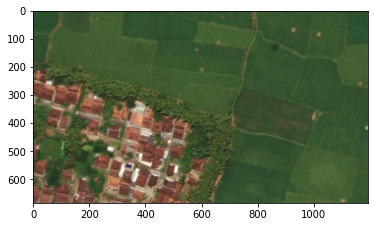

29
1479 29 51


In [ ]:
#Membaca Gambar Test Data dan Menampilkannya
img_path = "/content/drive/MyDrive/LCC/validasi/24.jpg"
img = load_img(img_path)
img = img_to_array(img)/255
plt.imshow(img)
plt.show()

#Membuat subimages dengan patches menggunkan metode sliding windows
patches = []
windows = sw.generate(img, sw.DimOrder.HeightWidthChannel, 56, 0.6)
for i,window in enumerate(windows):
    _img = img[window.indices()]
    patches.append(_img)
patches = np.array(patches)

#Mengecek total gambar dan banyaknya gambar yang terpasang pada height direction, maupun width direction
n_total = len(windows)
_x = 0
for i,window in enumerate(windows):
    if _x != window.x:
        n_x = i
        print(n_x)
        break
    _x = window.x


print(n_total,n_x,n_total//n_x)

(1479, 6)
(51, 29)
(1479, 6)


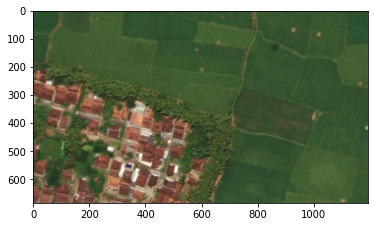

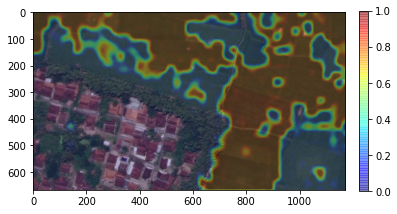

Minimal level zoomed : -0.31897107
Maximal level zoomed : 1.2329166
Minimal level ternomalisasi: 0.0
Maximal level ternomalisasi: 1.0

Banyaknya piksel yang terlihat dalam kelas  (0, 307050)
Akurasi dalam piksel (100%) : 39.245133501195056
(51, 29)
(1479, 6)


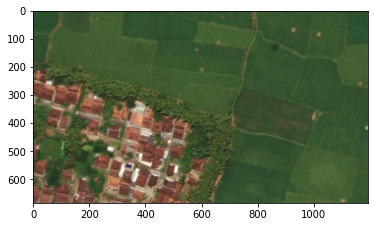

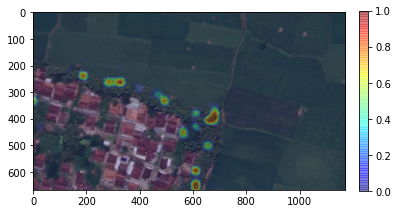

Minimal level zoomed : -0.24857312
Maximal level zoomed : 1.2348391
Minimal level ternomalisasi: 0.0
Maximal level ternomalisasi: 1.0

Banyaknya piksel yang terlihat dalam kelas  (1, 6370)
Akurasi dalam piksel (100%) : 0.8141719602755659
(51, 29)
(1479, 6)


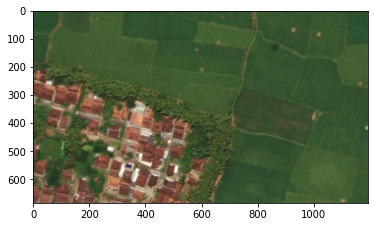

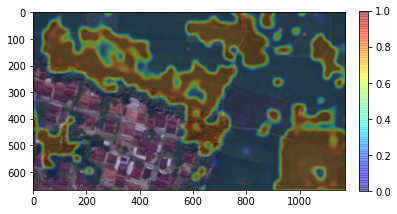

Minimal level zoomed : -0.2320517
Maximal level zoomed : 1.3525642
Minimal level ternomalisasi: 0.0
Maximal level ternomalisasi: 1.0

Banyaknya piksel yang terlihat dalam kelas  (2, 235745)
Akurasi dalam piksel (100%) : 30.13139227239612
(51, 29)
(1479, 6)


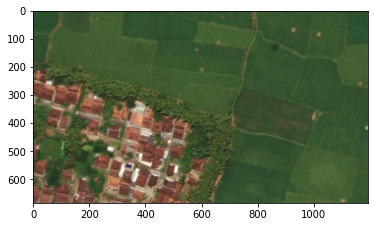

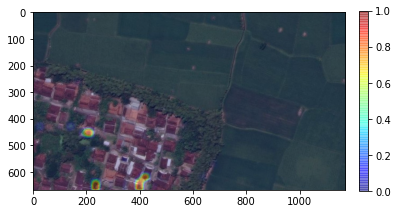

Minimal level zoomed : -0.21494663
Maximal level zoomed : 1.086463
Minimal level ternomalisasi: 0.0
Maximal level ternomalisasi: 1.0

Banyaknya piksel yang terlihat dalam kelas  (3, 3638)
Akurasi dalam piksel (100%) : 0.46498549316836874
(51, 29)
(1479, 6)


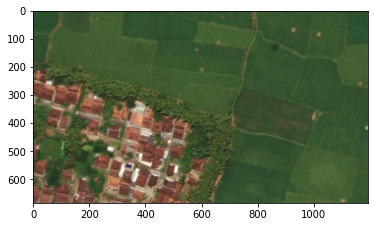

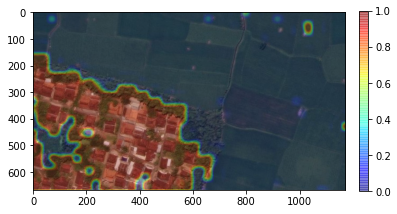

Minimal level zoomed : -0.31439042
Maximal level zoomed : 1.2793237
Minimal level ternomalisasi: 0.0
Maximal level ternomalisasi: 1.0

Banyaknya piksel yang terlihat dalam kelas  (4, 219133)
Akurasi dalam piksel (100%) : 28.00815450095221
(51, 29)
(1479, 6)


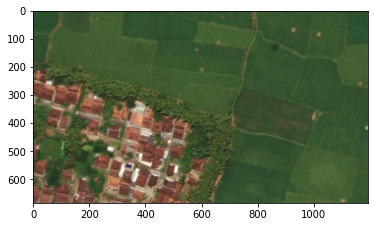

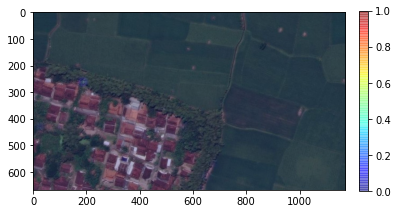

Minimal level zoomed : -0.027730143
Maximal level zoomed : 0.20378618
Minimal level ternomalisasi: 0.0
Maximal level ternomalisasi: 1.0

Banyaknya piksel yang terlihat dalam kelas  (5, 737)
Akurasi dalam piksel (100%) : 0.09419854548243203


In [ ]:
#Memprediksi probalititas keberadaaan tutupan terhadap gambar yang telah dicacah 
#dan kembali pada gambar original
predictions = model.predict(patches)
print(predictions.shape)
#print(predictions)
for i in range(6):
  kelas = np.reshape(predictions[:,i],(n_total//n_x,n_x))
  print(kelas.shape)
  kelas = np.rot90(kelas)
  kelas = np.rot90(kelas)
  kelas = np.rot90(kelas)
  kelas = np.flip(kelas,axis=-1)
#Array pada gambar diperbesar menggunakan  spline
  h_factor = img.shape[0]//kelas.shape[0]
  w_factor = img.shape[1]//kelas.shape[1]
  predictions = model.predict(patches)
  print(predictions.shape)
  from scipy.ndimage import zoom
  zoomed = zoom(kelas,(h_factor,w_factor))
#print(zoomed.shape)

#Menampilkan hasil gambar level tertentu
  plt.imshow(img)
  plt.show()

  plt.imshow(img)
  plt.imshow(zoomed,alpha=0.3,vmax=1.0,vmin=0,cmap="jet")

  plt.colorbar(fraction=0.027, pad=0.04,alpha=0)
  plt.show()

  #Memperoleh Nilai Akurasi data pengujian dalam piksel
  print("Minimal level zoomed :", np.min(zoomed))
  print("Maximal level zoomed :", np.max(zoomed))
  #Menampilkan nilai level zoomed dalam range 0 sampai 1
  normalized = (zoomed-np.min(zoomed))/(np.max(zoomed)-np.min(zoomed))
  print("Minimal level ternomalisasi:", np.min(normalized))
  print("Maximal level ternomalisasi:", np.max(normalized))
  print('')
  #Menghitung banyaknya piksel
  #Tingkatan level warna dari 0 sampai 1 yang mencapai bentuk sesuai dengan kelasnya.
  banyakpiksel=(normalized>0.5).sum()
  akurasi=((normalized>0.5).sum()*100/(normalized<1).sum())
  print("Banyaknya piksel yang terlihat dalam kelas ", (i, banyakpiksel))
  print("Akurasi dalam piksel (100%) :", (akurasi))

# Evaluasi Data Pelatihan terhadap Pengujian dalam Luas Lahan

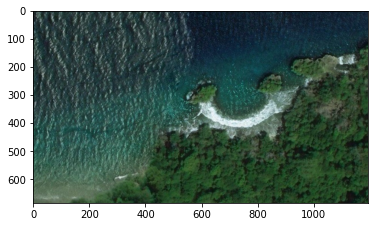

29
1479 29 51


In [ ]:
#Membaca Gambar Test Data dan Menampilkannya
img_path22 = "/content/drive/MyDrive/LCC/validasi/10.jpg"
img22 = load_img(img_path22)
img22 = img_to_array(img22)/255
plt.imshow(img22)
plt.show()

#Membuat subimages dengan patches menggunkan metode sliding windows
patches22 = []
windows22 = sw.generate(img22, sw.DimOrder.HeightWidthChannel, 56, 0.6)
for i,window in enumerate(windows22):
    _img22 = img22[window.indices()]
    patches22.append(_img22)
patches22 = np.array(patches22)

#Mengecek total gambar dan banyaknya gambar yang terpasang pada height direction, maupun width direction
n_total22 = len(windows22)
_x = 0
for i,window in enumerate(windows22):
    if _x != window.x:
        n_x22 = i
        print(n_x22)
        break
    _x = window.x


print(n_total22,n_x22,n_total22//n_x22)

(1479, 6)


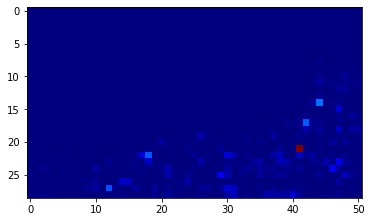

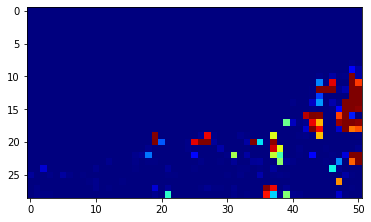

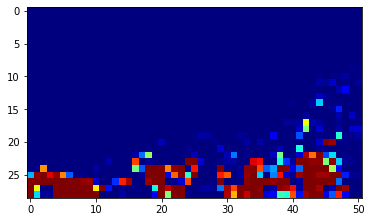

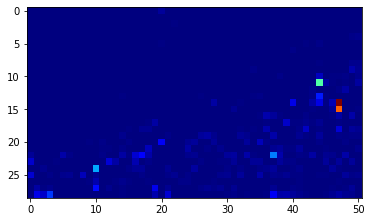

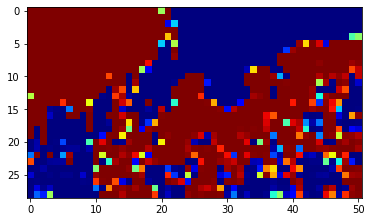

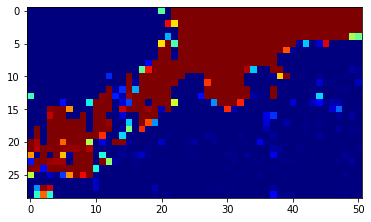

In [ ]:
#Memprediksi probalititas keberadaaan tutupan lahan tertentu terhadap gambar yang telah dicacah 
#dan kembali pada gambar original
from scipy.ndimage import zoom
predictions22 = model.predict(patches22)
print(predictions22.shape)
#print(predictions22)
full_pred={}
for i in range(predictions22.shape[1]) :
  full_pred[f"kelas22_{i}"] = np.reshape(predictions22[:,i],(n_total22//n_x22,n_x22))
  full_pred[f"kelas22_{i}"] = np.rot90(full_pred[f"kelas22_{i}"])
  full_pred[f"kelas22_{i}"] = np.rot90(full_pred[f"kelas22_{i}"])
  full_pred[f"kelas22_{i}"] = np.rot90(full_pred[f"kelas22_{i}"])
  full_pred[f"kelas22_{i}"] = np.flip(full_pred[f"kelas22_{i}"],axis=-1)
plt.imshow(full_pred['kelas22_0'],cmap="jet")

plt.show()
plt.imshow(full_pred['kelas22_1'],cmap="jet")

plt.show()
plt.imshow(full_pred['kelas22_2'],cmap="jet")

plt.show()
plt.imshow(full_pred['kelas22_3'],cmap="jet")

plt.show()
plt.imshow(full_pred['kelas22_4'],cmap="jet")

plt.show()
plt.imshow(full_pred['kelas22_5'],cmap="jet")

plt.show()

In [ ]:
from scipy.ndimage import zoom
h_factor22_0 = img22.shape[0]//full_pred['kelas22_0'].shape[0]
w_factor22_0 = img22.shape[1]//full_pred['kelas22_0'].shape[1]
print(h_factor22_0)

zoomed22_0 = zoom(full_pred['kelas22_0'],(h_factor22_0,w_factor22_0))
print(zoomed22_0.shape)
print("\n")

h_factor22_1 = img22.shape[0]//full_pred['kelas22_1'].shape[0]
w_factor22_1 = img22.shape[1]//full_pred['kelas22_1'].shape[1]
print(h_factor22_1)
zoomed22_1 = zoom(full_pred['kelas22_1'],(h_factor22_1,w_factor22_1))
print(zoomed22_1.shape)
print("\n")
h_factor22_2 = img22.shape[0]//full_pred['kelas22_2'].shape[0]
w_factor22_2 = img22.shape[1]//full_pred['kelas22_2'].shape[1]
print(h_factor22_2)
zoomed22_2 = zoom(full_pred['kelas22_2'],(h_factor22_2,w_factor22_2))
print(zoomed22_2.shape)
print("\n")
h_factor22_3 = img22.shape[0]//full_pred['kelas22_3'].shape[0]
w_factor22_3 = img22.shape[1]//full_pred['kelas22_3'].shape[1]
print(h_factor22_3)

zoomed22_3 = zoom(full_pred['kelas22_3'],(h_factor22_3,w_factor22_3))
print(zoomed22_3.shape)
print("\n")

h_factor22_4 = img22.shape[0]//full_pred['kelas22_4'].shape[0]
w_factor22_4 = img22.shape[1]//full_pred['kelas22_4'].shape[1]
print(h_factor22_4)

zoomed22_4 = zoom(full_pred['kelas22_4'],(h_factor22_4,w_factor22_4))
print(zoomed22_4.shape)
print("\n")
h_factor22_5 = img22.shape[0]//full_pred['kelas22_5'].shape[0]
w_factor22_5 = img22.shape[1]//full_pred['kelas22_5'].shape[1]
print(h_factor22_5)

zoomed22_5 = zoom(full_pred['kelas22_5'],(h_factor22_5,w_factor22_5))
print(zoomed22_5.shape)
print("\n")

23
(667, 1173)


23
(667, 1173)


23
(667, 1173)


23
(667, 1173)


23
(667, 1173)


23
(667, 1173)




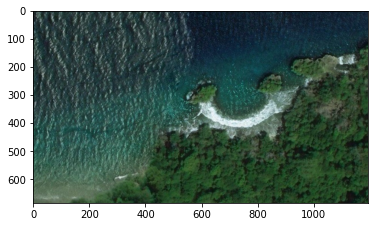

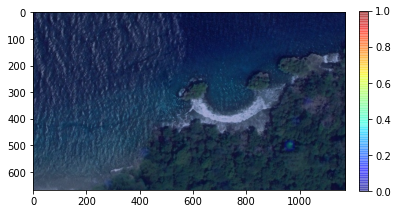

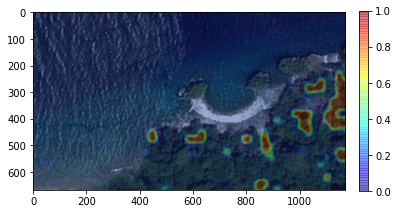

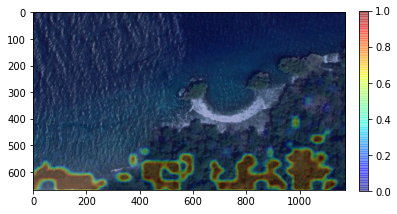

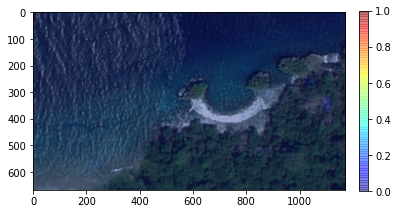

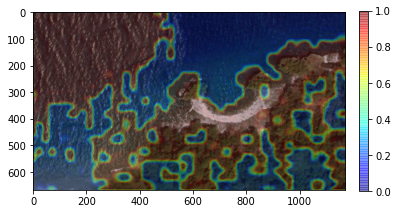

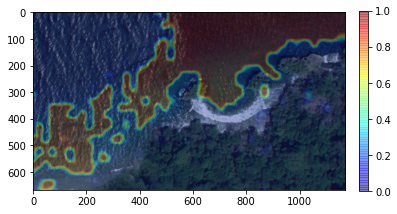

In [ ]:
  plt.imshow(img22)
  plt.show()

  plt.imshow(img22)
  plt.imshow(zoomed22_0,alpha=0.3,vmax=1.0,vmin=0,cmap="jet")

  plt.colorbar(fraction=0.027, pad=0.04,alpha=0)
  plt.show()

  plt.imshow(img22)
  plt.imshow(zoomed22_1,alpha=0.3,vmax=1.0,vmin=0,cmap="jet")

  plt.colorbar(fraction=0.027, pad=0.04,alpha=0)
  plt.show()

  plt.imshow(img22)
  plt.imshow(zoomed22_2,alpha=0.3,vmax=1.0,vmin=0,cmap="jet")

  plt.colorbar(fraction=0.027, pad=0.04,alpha=0)
  plt.show()

  plt.imshow(img22)
  plt.imshow(zoomed22_3,alpha=0.3,vmax=1.0,vmin=0,cmap="jet")

  plt.colorbar(fraction=0.027, pad=0.04,alpha=0)
  plt.show()

  plt.imshow(img22)
  plt.imshow(zoomed22_4,alpha=0.3,vmax=1.0,vmin=0,cmap="jet")

  plt.colorbar(fraction=0.027, pad=0.04,alpha=0)
  plt.show()

  plt.imshow(img22)
  plt.imshow(zoomed22_5,alpha=0.3,vmax=1.0,vmin=0,cmap="jet")

  plt.colorbar(fraction=0.027, pad=0.04,alpha=0)
  plt.show()

##Menampilkan Luas Tutupan Lahan yang berwarna Merah


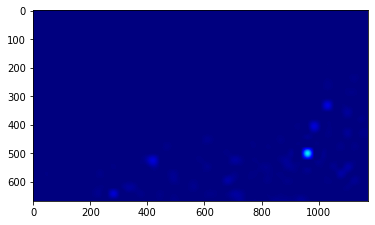

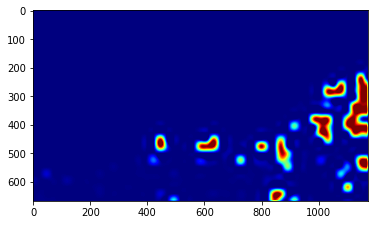

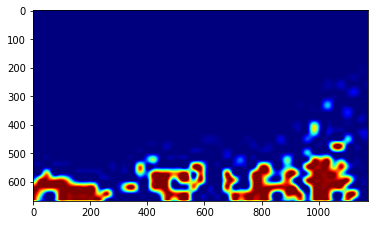

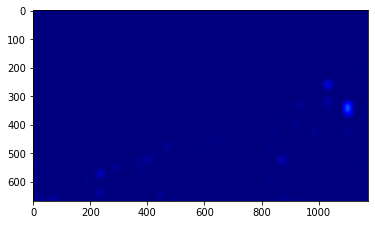

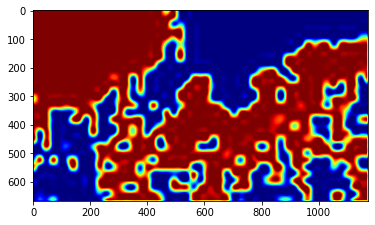

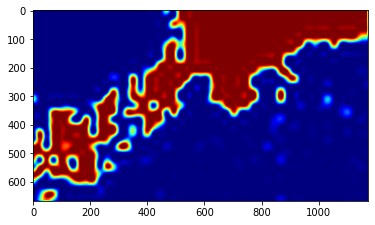

In [ ]:
plt.imshow(zoomed22_0,alpha=1,vmax=1.0,vmin=0,cmap="jet")
plt.show()
plt.imshow(zoomed22_1,alpha=1,vmax=1.0,vmin=0,cmap="jet")
plt.show()
plt.imshow(zoomed22_2,alpha=1,vmax=1.0,vmin=0,cmap="jet")
plt.show()
plt.imshow(zoomed22_3,alpha=1,vmax=1.0,vmin=0,cmap="jet")
plt.show()
plt.imshow(zoomed22_4,alpha=1,vmax=1.0,vmin=0,cmap="jet")
plt.show()
plt.imshow(zoomed22_5,alpha=1,vmax=1.0,vmin=0,cmap="jet")
plt.show()

## Menghitung Luas Tutupan Lahan Berwarna Merah

In [ ]:
#Menampilkan nilai level zoomed dalam range acak
print("Minimal level zoomed kelas sawah:", np.min(zoomed22_0))
print("Maximal level zoomed kelas sawah:", np.max(zoomed22_0))
print("\n")
#Menampilkan nilai level zoomed dalam range acak
print("Minimal level zoomed kelas hutan dan sawit:", np.min(zoomed22_1))
print("Maximal level zoomed kelas hutan dan sawit:", np.max(zoomed22_1))
print("\n")
#Menampilkan nilai level zoomed dalam range acak
print("Minimal level zoomed kelas perkebunan:", np.min(zoomed22_2))
print("Maximal level zoomed kelas perkebunan:", np.max(zoomed22_2))
print("\n")
#Menampilkan nilai level zoomed dalam range acak
print("Minimal level zoomed kelas tanah lapang:", np.min(zoomed22_3))
print("Maximal level zoomed kelas tanah lapang:", np.max(zoomed22_3))
print("\n")
#Menampilkan nilai level zoomed dalam range acak
print("Minimal level zoomed kelas permukiman:", np.min(zoomed22_4))
print("Maximal level zoomed kelas permukiman:", np.max(zoomed22_4))
print("\n")
#Menampilkan nilai level zoomed dalam range acak
print("Minimal level zoomed kelas perairan:", np.min(zoomed22_5))
print("Maximal level zoomed kelas perairan:", np.max(zoomed22_5))
print("\n")

Minimal level zoomed kelas sawah: -0.049607478
Maximal level zoomed kelas sawah: 0.36850145


Minimal level zoomed kelas hutan dan sawit: -0.22423957
Maximal level zoomed kelas hutan dan sawit: 1.2370902


Minimal level zoomed kelas perkebunan: -0.25216702
Maximal level zoomed kelas perkebunan: 1.3978093


Minimal level zoomed kelas tanah lapang: -0.028204184
Maximal level zoomed kelas tanah lapang: 0.21014027


Minimal level zoomed kelas permukiman: -0.39797717
Maximal level zoomed kelas permukiman: 1.2957155


Minimal level zoomed kelas perairan: -0.285793
Maximal level zoomed kelas perairan: 1.267697




In [ ]:
#Menampilkan nilai level zoomed dalam range 0 sampai 1
normalized22_0 = (zoomed22_0-np.min(zoomed22_0))/(np.max(zoomed22_0)-np.min(zoomed22_0))
print("Minimal level ternomalisasi:", np.min(normalized22_0))
print("Maximal level ternomalisasi:", np.max(normalized22_0))
print("\n")
#Menampilkan nilai level zoomed dalam range 0 sampai 1
normalized22_1 = (zoomed22_1-np.min(zoomed22_1))/(np.max(zoomed22_1)-np.min(zoomed22_1))
print("Minimal level ternomalisasi:", np.min(normalized22_1))
print("Maximal level ternomalisasi:", np.max(normalized22_1))
print("\n")
#Menampilkan nilai level zoomed dalam range 0 sampai 1
normalized22_2 = (zoomed22_2-np.min(zoomed22_2))/(np.max(zoomed22_2)-np.min(zoomed22_2))
print("Minimal level ternomalisasi:", np.min(normalized22_2))
print("Maximal level ternomalisasi:", np.max(normalized22_2))
print("\n")
#Menampilkan nilai level zoomed dalam range 0 sampai 1
normalized22_3 = (zoomed22_3-np.min(zoomed22_3))/(np.max(zoomed22_3)-np.min(zoomed22_3))
print("Minimal level ternomalisasi:", np.min(normalized22_3))
print("Maximal level ternomalisasi:", np.max(normalized22_3))
print("\n")
#Menampilkan nilai level zoomed dalam range 0 sampai 1
normalized22_4 = (zoomed22_4-np.min(zoomed22_4))/(np.max(zoomed22_4)-np.min(zoomed22_4))
print("Minimal level ternomalisasi:", np.min(normalized22_4))
print("Maximal level ternomalisasi:", np.max(normalized22_4))
print("\n")
#Menampilkan nilai level zoomed dalam range 0 sampai 1
normalized22_5 = (zoomed22_5-np.min(zoomed22_5))/(np.max(zoomed22_5)-np.min(zoomed22_5))
print("Minimal level ternomalisasi:", np.min(normalized22_5))
print("Maximal level ternomalisasi:", np.max(normalized22_5))
print("\n")

Minimal level ternomalisasi: 0.0
Maximal level ternomalisasi: 1.0


Minimal level ternomalisasi: 0.0
Maximal level ternomalisasi: 1.0


Minimal level ternomalisasi: 0.0
Maximal level ternomalisasi: 1.0


Minimal level ternomalisasi: 0.0
Maximal level ternomalisasi: 1.0


Minimal level ternomalisasi: 0.0
Maximal level ternomalisasi: 1.0


Minimal level ternomalisasi: 0.0
Maximal level ternomalisasi: 1.0




In [ ]:
#Menghitung luas tutupan lahan dalam piksel
#Tingkatan level warna dari 0 sampai 1 yang mencapai bentuk sesuai dengan kelasnya.
luaspiksel22_0=(normalized22_0>0.5).sum()
akurasi22_0=((normalized22_0>0.5).sum()*100/(normalized22_0<1).sum())
print("Luas Sawah dalam piksel :", (luaspiksel22_0))
print("Persentase Sawah dalam piksel (100%) :", (akurasi22_0))
print("\n")
#Menghitung luas tutupan lahan dalam piksel
#Tingkatan level warna dari 0 sampai 1 yang mencapai bentuk sesuai dengan kelasnya.
luaspiksel22_1=(normalized22_1>0.5).sum()
akurasi22_1=((normalized22_1>0.5).sum()*100/(normalized22_1<1).sum())
print("Luas hutan dan/atau sawit dalam piksel :", (luaspiksel22_1))
print("Persentase hutan dan/atau dalam piksel (100%) :", (akurasi22_1))
print("\n")
#Menghitung luas tutupan lahan dalam piksel
#Tingkatan level warna dari 0 sampai 1 yang mencapai bentuk sesuai dengan kelasnya.
luaspiksel22_2=(normalized22_2>0.5).sum()
akurasi22_2=((normalized22_2>0.5).sum()*100/(normalized22_2<1).sum())
print("Luas perkebunan dalam piksel :", (luaspiksel22_2))
print("Persentase perkebunan dalam piksel (100%) :", (akurasi22_2))
print("\n")
#Menghitung luas tutupan lahan dalam piksel
#Tingkatan level warna dari 0 sampai 1 yang mencapai bentuk sesuai dengan kelasnya.
luaspiksel22_3=(normalized22_3>0.5).sum()
akurasi22_3=((normalized22_3>0.5).sum()*100/(normalized22_3<1).sum())
print("Luas tanah lapang dalam piksel :", (luaspiksel22_3))
print("Persentase tanah lapang dalam piksel (100%) :", (akurasi22_3))
print("\n")
#Menghitung luas tutupan lahan dalam piksel
#Tingkatan level warna dari 0 sampai 1 yang mencapai bentuk sesuai dengan kelasnya.
luaspiksel22_4=(normalized22_4>0.5).sum()
akurasi22_4=((normalized22_4>0.5).sum()*100/(normalized22_4<1).sum())
print("Luas permukiman dalam piksel :", (luaspiksel22_4))
print("Persentase permukiman dalam piksel (100%) :", (akurasi22_4))
print("\n")
#Menghitung luas tutupan lahan dalam piksel
#Tingkatan level warna dari 0 sampai 1 yang mencapai bentuk sesuai dengan kelasnya.
luaspiksel22_5=(normalized22_5>0.5).sum()
akurasi22_5=((normalized22_5>0.5).sum()*100/(normalized22_5<1).sum())
print("Luas perairan dalam piksel :", (luaspiksel22_5))
print("Persentase perairan dalam piksel (100%) :", (akurasi22_5))
print("\n")

Luas Sawah dalam piksel : 723
Persentase Sawah dalam piksel (100%) : 0.09240915655874947


Luas hutan dan/atau sawit dalam piksel : 26379
Persentase hutan dan/atau dalam piksel (100%) : 3.3715921727015936


Luas perkebunan dalam piksel : 66441
Persentase perkebunan dalam piksel (100%) : 8.492056391313795


Luas tanah lapang dalam piksel : 1101
Persentase tanah lapang dalam piksel (100%) : 0.14072265749817867


Luas permukiman dalam piksel : 459496
Persentase permukiman dalam piksel (100%) : 58.72978949117448


Luas perairan dalam piksel : 225694
Persentase perairan dalam piksel (100%) : 28.846738838686587




"Validitas Pengukuran di Lapangan"

![image](https://raw.githubusercontent.com/Gio1709/paddy_100m/master/Validitas%20Pengukuran.jpg)

Untuk validasi/keakuratan perhitungan konversi nilai piksel pada meter, saya memiliki pengukuran secara langsung di lapangan. Objek yang digunakan sebagai pengukuran tersebut dilakukan pada **lebar jalan di depan rumah**. **Lokasi terletak di Dusun II RT 02/RW 07, Sokaraja Tengah, Kecamatan Sokaraja, Kabupaten Banyumas, Provinsi Jawa Tengah.**

Dengan menggunakan **alat ukur meteran**, diperoleh lebar jalan sebesar **2,71 meter.** Dapat dilihat lebih detail pada gambar.




**"Validasi Nilai Piksel ke dalam Meter"**

![image](https://raw.githubusercontent.com/Gio1709/paddy_100m/master/New%20Gambar%20100m.jpg)

Dapat dilakukan dengan langkah-langkah sbb :
1.   Menzoom/memperbesar sampel gambar (sampai batas maksimum).
2.   Menghitung jumlah piksel, sebagai contoh pada objek lebar jalan. Dimana didapatkan lebarnya sebesar 2,71 meter melalui fitur pengukuran pada Google Earth. Begitu pula dengan validitas pengukuran di lapangan pada lokasi yang sama diperoleh lebar sebesar 2,71 meter.[Resolusi Gambar adalah 1116x632 piksel]
3.   Pada ketinggian 100 meter, dapat dikalkulasi nilai lebar jalan dalam piksel, disini berjumlah 40 piksel. Lalu dilakukan perhitungan sebagai berikut :
    *   Nilai Meter/Piksel(**M/P**) = **M**(meter) / **P**(piksel)
                           = 2,71 meter / 40 piksel
                           = 0,06775 m/p 
                           ~= 0,068 m/p

Maka konversi 1 piksel menjadi meter pada gambar ini sebesar 0,068

Untuk menghitung luas maka dilakukan dengan 0,068 x 0,068 = 0,004624 (m/p)^2

In [ ]:
#Setelah diketahui luas sawah dalam piksel, kemudian menkonversi dalam meter dan hektar
#Untuk menghitung luas maka dilakukan dengan 0,3 x 0,3 = 0,09 
luasmtr = 0.004624*(luaspiksel22)
luasha = (luasmtr)/10000
print("Luas lahan sawah dalam meter persegi :", (luasmtr))
print("Luas lahan sawah dalam hektar :", (luasha))

# Perbandingan Hasil Luas Lahan dengan Fitur pada Google Earth

![image](https://raw.githubusercontent.com/Gio1709/paddy_100m/master/Perbandingan%20Google.jpg)

Hasil yang diperoleh pada fitur pengukuran luas lahan dalam hektar pada Google Earth didapatkan hasil sebesar 0,20 Hektar. Akan tetapi perlu diperhatikan dataset pengujian/testing yang digunakan dalam pengukuran lahan sawah mesti pada ketinggian yang sama dengan dataset pelatihan/training. 

Pada bagian ini diketahui ketinggiannya adalah 100 meter.